# Imports

In [24]:
import warnings
import itertools
warnings.filterwarnings("ignore")

In [2]:
import os
import tqdm
import numpy as np
import scipy as sp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

from IPython.display import display

In [3]:
import mne
print(mne.__file__)
print(mne.__version__)

/opt/homebrew/lib/python3.11/site-packages/mne/__init__.py
1.6.0


In [4]:
# Configure the graphics engine
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rc('figure', max_open_warning=200)

In [5]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [6]:
# My modules
import my_stageprocess as spr

# Global variables

In [7]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 10

In [8]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)

In [9]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal', ['Fp']), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal', ['LF']), 
               (['Fz','FCz'], 'MF', 'Midline Frontal', ['MF']), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal', ['RF']),
               (['T3','TP7','T5'], 'LT', 'Left Temporal', ['LT']), (['T4','TP8','T6'], 'RT', 'Right Temporal', ['RT']), 
               (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central', ['LC','MC','RC']), 
               (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal', ['LP','MP','RP']), 
               (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital', ['LO','MO','RO'])]

n_regions = len(regions)
n_regions_plt = len(regions_plt)

# Loading data

## Main data

In [10]:
# Loading epochs (Meditator data)

epochs_filt_rr = mne.read_epochs('../data/epochs_filt_rr-epo.fif')
print(epochs_filt_rr.get_data().shape)

sampling_rate = epochs_filt_rr.info['sfreq']
n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])

ch_names = epochs_filt_rr.ch_names
n_channels = len(ch_names)
print(ch_names)

Reading /Users/ttpo100ajiex/Desktop/HSE/CourseProject/m10/traditional/../data/epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
(1046, 40, 501)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


In [11]:
# Loading main features DataFrames

df_ft_psd_loc_db = pd.read_feather('features/df_ft_psd_loc_db.feather')
df_ft_psd_ind_loc_log = pd.read_feather('features/df_ft_psd_ind_loc_log.feather')
df_ft_coh_ind_loc = pd.read_feather('features/df_ft_coh_ind_loc.feather')
df_ft_plv_ind_loc = pd.read_feather('features/df_ft_plv_ind_loc.feather')

df_ft_psd_all_db = pd.read_feather('features/df_ft_psd_all_db.feather')
df_ft_coh_ind_all = pd.read_feather('features/df_ft_coh_ind_all.feather')
df_ft_plv_ind_all = pd.read_feather('features/df_ft_plv_ind_all.feather')

In [12]:
# Scaling features data

# PSD & PSD indices
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)

ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)

# Coherence indices
ft_coh_ind_loc_sc = StandardScaler().fit_transform(df_ft_coh_ind_loc.to_numpy())
df_ft_coh_ind_loc_sc = pd.DataFrame(ft_coh_ind_loc_sc, columns=df_ft_coh_ind_loc.columns)

# PLV indices
ft_plv_ind_loc_sc = StandardScaler().fit_transform(df_ft_plv_ind_loc.to_numpy())
df_ft_plv_ind_loc_sc = pd.DataFrame(ft_plv_ind_loc_sc, columns=df_ft_plv_ind_loc.columns)

# Clusterization functions

## Utlities

In [13]:
# Функция для расчёта оценок качетва кластеризации
def cluster_metrics_noground(name, data, labels_pred):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])

    # Define the metrics which require only data and predicted labels
    cluster_metrics = [
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
        metrics.davies_bouldin_score
    ]
    results += [m(data, labels_pred) for m in cluster_metrics]

    df_data.loc[0] = results
    
    return df_data

In [14]:
def apply_cluster_method(data, cl_method, name, df_metrics, **kwargs):
    method = cl_method(**kwargs).fit(data)
    
    df = cluster_metrics_noground(name, data, method.labels_)
    df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    return method, df_metrics

In [15]:
# Calculating clustering noground metrics for adjacent pairs of stages (Silh, Cal-Har, Dav-Bold)
def calc_stage_metr_noground(df_features, st_edges):
    df_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
    
    for _st in range(1, len(st_edges)-1):
        name = 'St'+str(_st)+'_St'+str(_st+1)
        data = df_features.iloc[st_edges[_st-1]:st_edges[_st+1]].reset_index(drop=True)
        labels = [0 for i in range(st_edges[_st]-st_edges[_st-1])] + [1 for i in range(st_edges[_st+1]-st_edges[_st])]
        
        df = cluster_metrics_noground(name, data, labels)
        df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    df_metrics.rename(columns={'Method': 'Stages'}, inplace=True)

    return df_metrics


In [16]:
# Матрица связности для k соседних по времени эпох
#K_NEIGHBORS = 30

def knn_con_matr(X):
    n_samples = len(X)
    sm = sp.sparse.lil_matrix((n_samples, n_samples), dtype=np.int8)
    for i in range(n_samples):
        for j in range(n_samples):
            if abs(i-j)<=k_neighbours: sm[i,j]=1
    return sm.tocsr()


## Clustering process

#### Main data

In [17]:
# PCA decomposition

# Number of PCA compnents
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis = 1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])

n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)
#df_ft_tot_pca = pd.DataFrame(ft_tot_pca[:-2], columns=pca_comp_names) # for m8 (artifacts at the end)
n_samples = len(df_ft_tot_pca)
print(n_samples, df_ft_tot_pca.to_numpy().shape)

(1046, 15)
Explained variance 0.71
[0.211, 0.156, 0.069, 0.063, 0.046, 0.032, 0.026, 0.02, 0.018, 0.015, 0.013, 0.012, 0.01, 0.009, 0.009]
765
1046
1046 (1046, 15)


In [18]:
# Iterative automatic process of finding best clusterisation 

# Global variables
k_neighb_min = 20
k_neighb_max = 50
n_cl_min = 2
n_cl_max = 20

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process

st_dist_rate = 0.3

# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))

df_best_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges = pd.DataFrame(columns=['Len_min', 'N_clusters', 'K_neighb', 'Silh', 'St_edges'])

for n_clusters in tqdm.trange(n_cl_min, n_cl_max+1):
    for k_neighbours in range(k_neighb_min, k_neighb_max+1):
        # Clustering, Ward method        
        cl_name = 'ward_pca_' + str(n_clusters) + '_' + str(k_neighbours)
        cl_method, df_best_metrics = apply_cluster_method(df_features, AgglomerativeClustering, cl_name, df_best_metrics,
                                                          n_clusters = n_clusters, linkage = 'ward', connectivity = knn_con_matr)
        # Forming stages from clusters
        st_edges = spr.form_stages(cl_method.labels_)
        
        # Merging stages
        for st_len_min in len_st_thr:
            st_edges = spr.merge_stages_1st_step(df_features, st_edges, len_threshold=st_len_min) 
            st_edges = spr.merge_stages_2nd_step(df_features, st_edges, dist_threshold=st_dist_rate) 
            # Insert clusterization results into DataFrame
            silh_metric = df_best_metrics[df_best_metrics['Method']==cl_name].iloc[0]['Silh']
            new_row = {'Len_min': st_len_min, 'N_clusters': n_clusters, 'K_neighb': k_neighbours, 
                                       'Silh': silh_metric, 'St_edges': st_edges}
            df_st_edges = pd.concat([df_st_edges, pd.DataFrame([new_row])], ignore_index=True)
            # Print results
            # st_lengths = np.array([st_edges[i+1] - st_edges[i] for i in range(len(st_edges)-1)])
            # print(st_len_min, n_clusters, k_neighbours, len(st_lengths), st_edges, st_lengths)

15


100%|██████████| 19/19 [03:13<00:00, 10.16s/it]


In [19]:
display(df_best_metrics.sample(n = 25))
display(df_st_edges.sample(n = 25))

,Method,Silh,Cal-Har,Dav-Bold
346,ward_pca_13_25,0.06,83.68,2.49
355,ward_pca_13_34,0.08,95.99,2.42
441,ward_pca_16_27,0.06,79.48,2.42
17,ward_pca_2_37,0.14,132.06,2.00
210,ward_pca_8_44,0.09,119.43,2.67
436,ward_pca_16_22,0.06,77.45,2.26
453,ward_pca_16_39,0.07,83.99,2.37
81,ward_pca_4_39,0.15,156.76,2.23
76,ward_pca_4_34,0.16,150.91,2.43
149,ward_pca_6_45,0.10,138.11,2.43


,Len_min,N_clusters,K_neighb,Silh,St_edges
604,0,6,47,0.07,"[0, 39, 178, 284, 490, 560, 682, 857, 1020, 1046]"
616,0,6,50,0.08,"[0, 132, 284, 490, 560, 666, 681, 855, 1046]"
1655,60,15,30,0.08,"[0, 95, 282, 494, 557, 682, 784, 857, 975, 1046]"
2341,20,20,47,0.08,"[0, 39, 92, 154, 282, 492, 557, 682, 784, 855,..."
2234,40,20,20,0.06,"[0, 95, 168, 237, 310, 360, 492, 560, 609, 682..."
1695,60,15,40,0.07,"[0, 104, 282, 494, 557, 682, 784, 857, 972, 1046]"
804,0,8,35,0.08,"[0, 92, 237, 282, 490, 560, 666, 682, 784, 857..."
1174,40,11,34,0.07,"[0, 92, 156, 282, 494, 560, 682, 777, 857, 976..."
748,0,8,21,0.04,"[0, 95, 259, 490, 560, 609, 682, 870, 931, 977..."
302,40,4,33,0.14,"[0, 92, 282, 560, 681, 857, 976, 1046]"


#### Clusterization

In [41]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

cl_center_types = ['med', 'mode', 'mean']
n_st_edge_max = 15 # max number of resulting edge clusters

df_features = df_ft_tot_pca

df_st_edge_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_result = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for (st_len, k_nb_max, n_cl) in tqdm.contrib.itertools.product(len_st_thr, k_neighb_max_thr, n_cl_max_thr):
    # Forming st_edges_all list
    st_edges_all = []
    st_edges_list = []
    st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                        (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
    for _st_edges in st_edges_list:
        st_edges_all += _st_edges[1:-1].tolist()
    st_edges_all = sorted(st_edges_all)
    df_st_edges_all = pd.DataFrame(st_edges_all)
    
    # Clustering stage edges            
    for n_st_edge_clusters in range(2, n_st_edge_max+1):
        cl_name = ('kmeans_edges_'+str(n_st_edge_clusters)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
        cluster_method, df_st_edge_metrics = apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                                            n_clusters=n_st_edge_clusters, random_state=0)
        # Form stages by centers of clusters (median, mean, mode)
        st_clusters = []
        st_medians = []
        st_modes = []
        st_means = []
        for _st in range(n_st_edge_clusters):
            st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
            st_medians.append(int(np.median(st_clusters[_st])))
            mode, count = sp.stats.mode(st_clusters[_st])
            st_modes.append(mode)
            st_means.append(int(np.mean(st_clusters[_st])))
            
        st_edges_centers = []
        st_dist_w_avg = np.empty(len(cl_center_types))
        st_dist_c_avg = np.empty(len(cl_center_types))
        for _cen in range(len(cl_center_types)):
            if (cl_center_types[_cen] == 'med'):
                st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
            if (cl_center_types[_cen] == 'mode'):
                st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
            if (cl_center_types[_cen] == 'mean'):
                st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                
            # Calculating stage distabce
            st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
            st_dist_w_avg[_cen] = np.mean(st_dist_ward)
            st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                
            # Form resulting stage edges array
            #st_edges_result = st_edges_centers[_cen]
            cl_cen = cl_center_types[_cen]
                        
            # Calculating clustering metrics for stages
            st_bands, new_labels = spr.form_stage_bands(st_edges_centers[_cen], n_samples)
            n_stages = len(st_bands)
        
            name = ('stages_'+cl_cen+'_'+str(n_st_edge_clusters+1)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
            
            # Overall dataset clustering metrics for stages
            df = cluster_metrics_noground(name, df_features, new_labels)
            df_stage_metrics = df_stage_metrics.drop(df_stage_metrics[df_stage_metrics['Method']==name].index, 
                                                        errors='ignore')
            df_stage_metrics = pd.concat([df_stage_metrics, df], ignore_index=True)
                
            # Clustering metrics for pairs of adjacesnt stages                   
            df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_centers[_cen])
            silh = df_adj_st_metr['Silh'].mean()
            cal_har = df_adj_st_metr['Cal-Har'].mean()
            dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                
            # Insert stage edges into the DataFrame
            new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                        'N_cl_max': n_cl, 'Cl_cen': cl_cen, 'Ward_dist': st_dist_w_avg[_cen], 
                        'Cen_dist': st_dist_c_avg[_cen], 'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold,
                        'St_edges': st_edges_centers[_cen]}
            df_st_edges_result = pd.concat([df_st_edges_result, pd.DataFrame([new_row])], ignore_index=True)

  0%|          | 0/48 [00:00<?, ?it/s]

In [44]:
display(df_st_edge_metrics.sample(n = 15))
display(df_stage_metrics.sample(n = 15))
display(df_st_edges_result.sample(n = 15))

,Method,Silh,Cal-Har,Dav-Bold
124,kmeans_edges_14_0_45_20,0.81,"280,134.26",0.27
224,kmeans_edges_2_20_40_15,0.68,"7,842.69",0.42
79,kmeans_edges_11_0_40_20,0.76,"114,079.44",0.32
46,kmeans_edges_6_0_40_10,0.74,"20,702.61",0.39
170,kmeans_edges_4_20_35_10,0.70,"6,653.79",0.39
26,kmeans_edges_14_0_35_15,0.86,"165,051.21",0.21
132,kmeans_edges_8_0_50_10,0.77,"39,643.96",0.39
537,kmeans_edges_7_60_35_20,0.86,"54,919.40",0.21
336,kmeans_edges_2_40_35_10,0.68,"2,803.61",0.42
467,kmeans_edges_7_40_50_10,0.82,"37,712.79",0.27


,Method,Silh,Cal-Har,Dav-Bold
900,stages_med_9_20_50_10,0.03,79.19,2.93
519,stages_med_8_20_35_10,0.04,85.02,2.96
333,stages_med_16_0_45_15,0.03,58.98,3.05
1745,stages_mean_10_60_40_20,0.05,79.32,3.02
1296,stages_med_15_40_45_10,0.03,58.30,3.31
468,stages_med_5_0_50_20,0.07,77.64,3.27
1251,stages_med_14_40_40_20,0.04,64.42,3.03
687,stages_med_8_20_40_15,0.04,85.22,2.95
153,stages_med_12_0_40_10,0.04,71.21,2.94
1819,stages_mode_7_60_45_15,0.04,91.03,3.18


,N_stages,St_len_min,K_nb_max,N_cl_max,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
1720,16,60,40,15,mode,"10,333.84",16.21,0.15,32.18,2.40,"[0, 92, 124, 168, 206, 237, 259, 282, 360, 492..."
866,11,20,45,20,mean,"14,793.40",17.00,0.16,42.41,2.35,"[0, 73, 154, 264, 374, 492, 570, 680, 781, 857..."
989,10,20,50,20,mean,"16,863.39",17.97,0.17,48.29,2.08,"[0, 71, 155, 274, 481, 569, 680, 782, 857, 958..."
1589,14,60,35,15,mean,"12,768.50",17.17,0.17,38.44,2.13,"[0, 95, 124, 164, 206, 243, 281, 360, 491, 559..."
63,10,0,35,15,med,"18,962.07",19.35,0.19,55.65,1.89,"[0, 95, 168, 277, 492, 560, 682, 784, 857, 971..."
475,7,0,50,20,mode,"33,803.33",21.73,0.20,90.70,1.69,"[0, 39, 282, 560, 682, 857, 976, 1046]"
1505,14,40,50,20,mean,"11,832.11",17.87,0.18,39.55,2.14,"[0, 93, 128, 160, 231, 282, 491, 558, 609, 681..."
1726,4,60,40,20,mode,"37,546.99",16.88,0.13,86.09,2.39,"[0, 282, 682, 857, 1046]"
1751,12,60,40,20,mean,"14,810.04",18.08,0.17,43.79,2.03,"[0, 95, 125, 163, 233, 279, 492, 558, 681, 782..."
1800,15,60,45,10,med,"11,240.49",16.73,0.16,34.92,2.32,"[0, 92, 132, 168, 206, 235, 282, 360, 490, 560..."


In [47]:
# Plot parameters for each number of stages

min_stage_length = 0 # minimum acceptable stage length

df_st_edges_best = pd.DataFrame(columns=df_st_edges_result.columns)

for n_st in range(3,n_st_edge_max+2):
    df = df_st_edges_result[(df_st_edges_result['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]

    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best = pd.concat([df_st_edges_best, pd.DataFrame([new_row])], ignore_index=True)
    
display(df_st_edges_best)

,N_stages,St_len_min,K_nb_max,N_cl_max,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
0,3,0,35,10,mode,"42,305.92",16.40,0.13,108.77,2.44,"[0, 282, 560, 1046]"
1,4,20,40,15,med,"33,307.15",15.08,0.13,86.29,3.12,"[0, 168, 560, 857, 1046]"
2,5,40,50,10,med,"45,198.19",21.84,0.21,121.13,1.80,"[0, 178, 560, 682, 857, 1046]"
3,6,0,35,20,mode,"34,637.65",20.81,0.19,94.18,1.80,"[0, 39, 282, 560, 682, 857, 1046]"
4,7,0,40,20,mode,"33,803.33",21.73,0.20,90.70,1.69,"[0, 39, 282, 560, 682, 857, 976, 1046]"
5,8,60,45,20,med,"27,079.31",20.75,0.20,76.98,1.77,"[0, 104, 282, 557, 682, 784, 857, 976, 1046]"
6,9,0,45,20,mode,"24,210.13",21.38,0.20,69.91,1.64,"[0, 39, 282, 492, 560, 682, 784, 857, 976, 1046]"
7,10,0,40,15,mode,"19,921.90",19.98,0.20,59.06,1.80,"[0, 92, 154, 282, 492, 560, 682, 784, 857, 976..."
8,11,40,40,15,mode,"17,433.85",20.01,0.21,56.02,1.82,"[0, 92, 154, 282, 492, 560, 609, 682, 784, 857..."
9,12,40,45,20,mode,"15,555.04",19.78,0.20,51.40,1.89,"[0, 92, 154, 282, 492, 560, 609, 682, 784, 857..."


In [62]:
# Optimal number of clusters

n_stages = 10 # expert choise of result number of stages

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]

# Cluster center type
cl_center_type = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['Cl_cen'].iloc[0]
print(cl_center_type)

# Stage boundary epoch numbers
st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # results for m10
print(st_edges_result)

mode
[0, 92, 154, 282, 492, 560, 682, 784, 857, 976, 1046]


#### Analysis

mode
[0, 92, 154, 282, 492, 560, 682, 784, 857, 976, 1046]


Text(0.5, 0.98, 'Stage edge clusters')

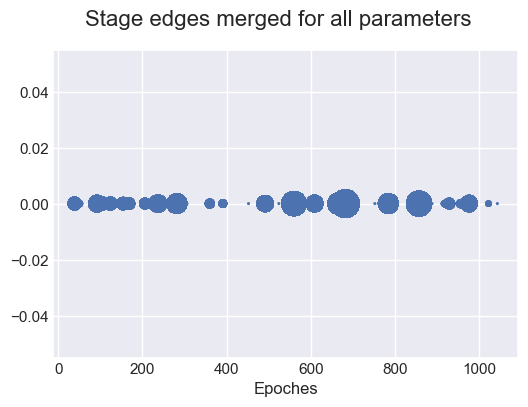

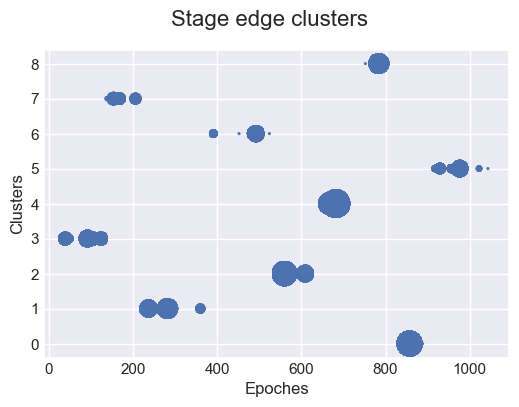

In [48]:
# Optimal number of clusters

n_stages = 10 # expert choise of result number of stages

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]

# Cluster center type
cl_center_type = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['Cl_cen'].iloc[0]
print(cl_center_type)

# Stage boundary epoch numbers
st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # results for m10
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'kmeans_edges_'+str(n_stages-1)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            n_clusters=n_stages-1, random_state=0)
edg_labels_all = cluster_method.labels_
   
# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)

# Plotting clusters    
x = st_edges_all
y = edg_labels_all
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)


In [58]:
# Find clustering statistic parameters (Main data)

df_st_edg_stats = pd.DataFrame(columns=['Cluster name', 'Median', 'Mean', 'Mode', 'Mode probability', 'Standard deviation', 
                                        'Median 0.95 confidence interval', 'Cluster size'])
st_clusters = []
for _st in range(n_stages-1):
    st_clusters.append([st_edges_all[i] for i in np.where(edg_labels_all == _st)[0]])
    mode, count = sp.stats.mode(st_clusters[_st])
    conf_int_median = spr.median_confidence_interval(pd.Series(st_clusters[_st]), cutoff=0.95)
    
    new_row = {'Cluster name': 'Boundary cluster '+str(_st), 'Median': int(np.median(st_clusters[_st])), 
               'Mean': int(np.array(st_clusters[_st]).mean()), 'Mode': mode, 
               'Mode probability': count/len(st_clusters[_st]), 'Standard deviation': int(np.array(st_clusters[_st]).std()), 
               'Median 0.95 confidence interval': conf_int_median, 'Cluster size': len(st_clusters[_st])}
    df_st_edg_stats = pd.concat([ df_st_edg_stats,  pd.DataFrame([ new_row ]) ], ignore_index = True)

df_st_edg_stats = df_st_edg_stats.sort_values('Median', ignore_index=True)
display(df_st_edg_stats)

,Cluster name,Median,Mean,Mode,Mode probability,Standard deviation,Median 0.95 confidence interval,Cluster size
0,Boundary cluster 3,95,91,92,0.26,27,"(92, 95)",347
1,Boundary cluster 7,168,170,154,0.29,20,"(156, 168)",169
2,Boundary cluster 1,259,263,282,0.30,32,"(237, 277)",427
3,Boundary cluster 6,492,483,492,0.37,28,"(492, 492)",227
4,Boundary cluster 2,560,571,560,0.53,21,"(560, 560)",369
5,Boundary cluster 4,682,675,682,0.57,9,"(682, 682)",444
6,Boundary cluster 8,784,782,784,0.76,3,"(784, 784)",170
7,Boundary cluster 0,857,858,857,0.84,4,"(857, 857)",245
8,Boundary cluster 5,971,961,976,0.29,25,"(971, 975)",303


In [59]:
# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

display(df_adj_st_metr)

,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.23,46.60,1.76,18.51,"12,693.88"
1,St2_St3,0.14,29.38,2.33,15.30,"9,781.58"
2,St3_St4,0.15,57.32,2.30,14.45,"16,614.57"
3,St4_St5,0.18,51.44,1.91,16.33,"13,703.35"
4,St5_St6,0.23,82.12,1.34,25.83,"29,124.39"
5,St6_St7,0.29,105.78,1.37,25.91,"37,280.49"
6,St7_St8,0.22,52.22,1.75,18.87,"15,143.87"
7,St8_St9,0.20,64.18,1.55,24.47,"27,098.85"
8,St9_St10,0.14,42.56,1.87,20.13,"17,856.16"


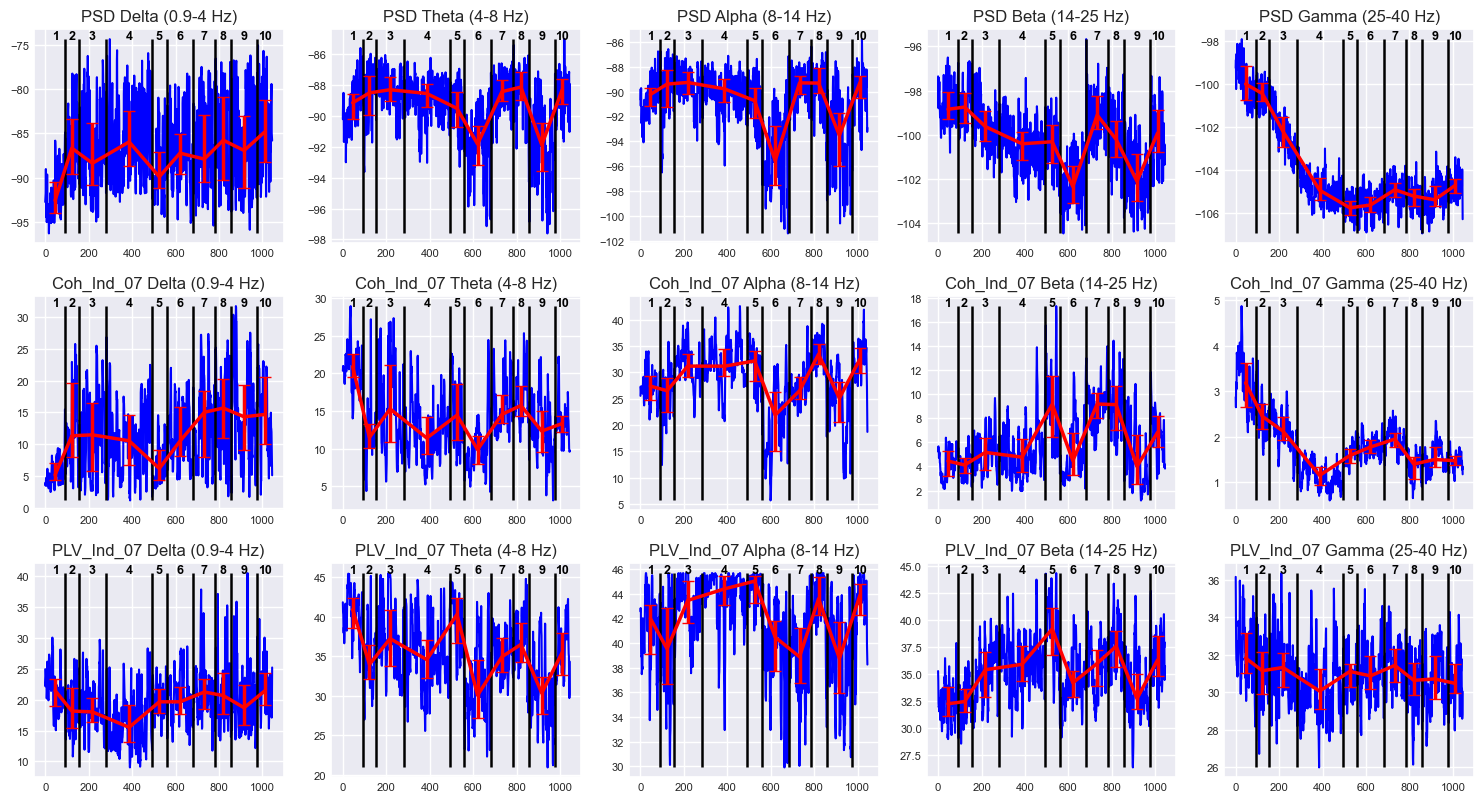

In [61]:
# Plotting overall PSD, Coherence and PLV with stage bounds

ind_rate = '07'

st_bands, st_labels = spr.form_stage_bands(st_edges_result, n_samples)
x_st = [(smin + smax)/2 for (smin, smax, _) in st_bands]
#st_names = [st_nm for (_, _, st_nm) in st_bands]

# Features DataFrames
df_ft_psd = df_ft_psd_all_db
df_cols = [col for col in df_ft_coh_ind_all.columns if (ind_rate in col)]
df_ft_coh = df_ft_coh_ind_all[df_cols]
df_cols = [col for col in df_ft_plv_ind_all.columns if (ind_rate in col)]
df_ft_plv = df_ft_plv_ind_all[df_cols]

# Initialize plots
n_cols = n_freq
n_rows = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
plt.subplots_adjust(left=0.02)

# PSD plots (1st row)
df_ft_clust = [df_ft_psd.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_psd.to_numpy()[:,i]  
    axs[0,i].plot(y, color='blue')
    axs[0,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[0,i].set_title("PSD "+ bands[i][2])
    axs[0,i].tick_params(axis='both', labelsize=8, direction='in')
    
    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[0,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')
    
    # Add text (stage index)
    for _st in range(n_stages):
        axs[0,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')
    
# Coherence plots (2nd row)
df_ft_clust = [df_ft_coh.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_coh.to_numpy()[:,i]
    axs[1,i].plot(y, color='blue')
    axs[1,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[1,i].set_title('Coh_Ind_'+ind_rate+' '+bands[i][2])
    axs[1,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[1,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')   

    # Add text (stage index)
    for _st in range(n_stages):
        axs[1,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')   
    
# PLV plots (3rd row)
df_ft_clust = [df_ft_plv.iloc[smin:(smax+1), :] for (smin, smax, _) in st_bands]
df_ft_clust_stats = [df_ft_clust[_cl].describe() for _cl in range(n_stages)]
for i in range(n_freq):
    y = df_ft_plv.to_numpy()[:,i]
    axs[2,i].plot(y, color='blue')
    axs[2,i].vlines(x=st_edges_result[1:-1], ymin=np.min(y), ymax=np.max(y), color='black', linewidth=1.8)
    axs[2,i].set_title('PLV_Ind_'+ind_rate+' '+bands[i][2])
    axs[2,i].tick_params(axis='both', labelsize=8, direction='in')

    # Error bars (statistic plots)
    y_st = [df_ft_clust_stats[_cl].loc['50%'][i] for _cl in range(n_stages)]
    yerr = np.array([df_ft_clust_stats[_cl].loc[['25%','75%']].to_numpy() for _cl in range(n_stages)])[:,:,i].transpose(1,0)
    yerr[0,:] = y_st - yerr[0,:]
    yerr[1,:] = yerr[1,:] - y_st
    axs[2,i].errorbar(x_st, y_st, yerr, capsize=4, linewidth=2.5, color='red')       

    # Add text (stage index)
    for _st in range(n_stages):
        axs[2,i].text(x_st[_st], np.max(y), _st+1, fontsize=9, color='black', horizontalalignment='center', fontweight='bold')   
    
plt.tight_layout(rect=[0,0.09,1,1])


# Results

In [63]:
# Load partition into stages
print(st_edges_result)

# Form stage bands
st_bands, st_labels = spr.form_stage_bands(st_edges_result, n_samples)
n_stages = len(st_bands)


[0, 92, 154, 282, 492, 560, 682, 784, 857, 976, 1046]


In [64]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis=1)
#df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc], axis=1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)
#df_ft_tot_pca = pd.DataFrame(ft_tot_pca[:-2], columns=pca_comp_names) # for m8 (artifacts at the end)
n_samples = len(df_ft_tot_pca)
print(n_samples, df_ft_tot_pca.to_numpy().shape)

(1046, 15)
Explained variance 0.71
[0.211, 0.156, 0.069, 0.063, 0.046, 0.032, 0.026, 0.02, 0.018, 0.015, 0.013, 0.012, 0.01, 0.009, 0.009]
765
1046
1046 (1046, 15)


In [65]:
# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))

15


In [73]:
# Calculate stage distances & clustering quality metrics

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Max distance values for plotting
st_dist_centr_max = np.max(np.concatenate([ st_dist_centr ]))
st_dist_ward_max = np.max(np.concatenate((st_dist_ward,)))
st_metr_silh_max = np.max(np.concatenate((st_metr_silh,)))
st_metr_calh_max = np.max(np.concatenate((st_metr_calh,)))
st_metr_davb_max = np.max(np.concatenate((st_metr_davb,)))

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)

Centr: 25.91  Silh: 0.29  Davb: 2.33  Ward: 37280.3  Calh: 105.79


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.23,46.62,1.76,18.52,"12,698.85"
1,St2_St3,0.14,29.38,2.33,15.30,"9,782.43"
2,St3_St4,0.15,57.33,2.30,14.46,"16,617.94"
3,St4_St5,0.17,51.43,1.91,16.33,"13,701.88"
4,St5_St6,0.23,82.11,1.34,25.83,"29,122.11"
5,St6_St7,0.29,105.79,1.37,25.91,"37,280.30"
6,St7_St8,0.22,52.22,1.75,18.87,"15,143.22"
7,St8_St9,0.20,64.18,1.55,24.47,"27,099.21"
8,St9_St10,0.14,42.55,1.87,20.13,"17,854.50"


## Main data

[79, 56, 117, 191, 55, 107, 86, 63, 105, 61]


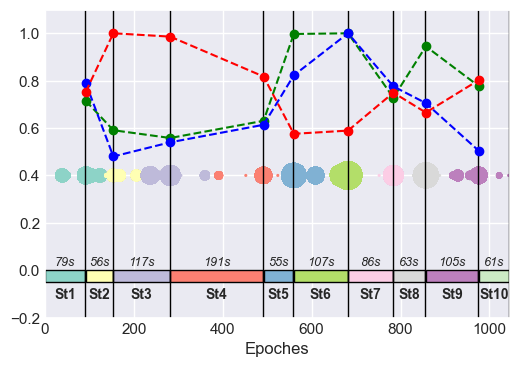

In [75]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca
st_bands, st_labels = spr.form_stage_bands(st_edges_result, n_samples)
n_stages = len(st_bands)

# Sorting cluster labels for st_edges_all
#edg_labels_all = cluster_method.labels_
labels_uq = sorted(set(edg_labels_all), key=list(edg_labels_all).index)
edg_labels_sort = []
for _cl in range(len(labels_uq)):
    edg_labels_sort += [_cl for i in np.where(edg_labels_all == labels_uq[_cl])[0]]

# Getting time length of the stages
cluster_events = epochs_filt_rr.events.copy() # for m10 and m3
#cluster_events = epochs_filt_rr[:-2].events.copy() # for m8 (artifacts at the end)
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]
print(st_time_len)

# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           facecolor = pal(_st/(n_stages)), fill=True, lw=1)) # for 8 stages
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           #facecolor = pal(_st/(n_stages+1)), fill=True, lw=1)) # for 10 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines
    
    # Background colors
    #ax.axvspan(x_start, x_end, alpha=0.3, color=pal(_st/(n_stages-1)))

    # Scatter plot
    x_sc = [st_edges_all[i] for i in range(len(st_edges_all)) if edg_labels_sort[i]==_st]
    y_sc = np.full(len(x_sc), 0.4)
    s = [1.5*x_sc.count(x_sc[i]) for i in range(len(x_sc))]
    ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages))) # for 8 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages-1))) # for 9 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages+1))) # for 10 stages
    
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.12, st_name, fontsize=10, fontweight='bold', horizontalalignment='center')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    
# Adjacent stage distances (Centroid) & Silh coef 
x_dist = st_edges_result[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centroid distance')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silhouette score')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Davies-Bouldin score')

ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')

In [78]:
# Getting time length of the stages

st_names =['Stage '+str(i+1) for i in range(n_stages)]
df_st_time_len = pd.DataFrame(columns=['Parameters']+st_names)

time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], 'St'+str(i+1)))

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands[i][0]/sampling_rate), round(time_bands[i][1]/sampling_rate))) 
                      for i in range(n_stages)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len = pd.concat([ df_st_time_len, pd.DataFrame([ new_row ]) ], ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands[i][1]-time_bands[i][0])/sampling_rate)) for i in range(n_stages)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len = pd.concat([ df_st_time_len, pd.DataFrame([ new_row ]) ], ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands[i][1]-st_bands[i][0]+1) for i in range(n_stages)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len = pd.concat([ df_st_time_len, pd.DataFrame([ new_row ]) ], ignore_index = True)

print(time_bands)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands])

display(df_st_time_len)


{'Stage 1': 92, 'Stage 2': 62, 'Stage 3': 128, 'Stage 4': 210, 'Stage 5': 68, 'Stage 6': 122, 'Stage 7': 102, 'Stage 8': 73, 'Stage 9': 119, 'Stage 10': 70}
[(4950, 44550, 'St1'), (44950, 72950, 'St2'), (73350, 131750, 'St3'), (132150, 227750, 'St4'), (228150, 255750, 'St5'), (256550, 310150, 'St6'), (310550, 353750, 'St7'), (354150, 385750, 'St8'), (386150, 438550, 'St9'), (438950, 469350, 'St10')]
[(79.2, 'St1'), (56.0, 'St2'), (116.8, 'St3'), (191.2, 'St4'), (55.2, 'St5'), (107.2, 'St6'), (86.4, 'St7'), (63.2, 'St8'), (104.8, 'St9'), (60.8, 'St10')]


,Parameters,Stage 1,Stage 2,Stage 3,Stage 4,Stage 5,Stage 6,Stage 7,Stage 8,Stage 9,Stage 10
0,"Start-end time, sec","(10, 89)","(90, 146)","(147, 264)","(264, 456)","(456, 512)","(513, 620)","(621, 708)","(708, 772)","(772, 877)","(878, 939)"
1,"Time length, sec",79.2,56.0,116.8,191.2,55.2,107.2,86.4,63.2,104.8,60.8
2,Number of epochs,92,62,128,210,68,122,102,73,119,70


In [79]:
# DataFrame with stage distances (by adjacent pairs)

df_features = df_ft_tot_pca

# Forming DataFrame with distance values    
st_dist_names = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages)]
df_st_dist_pairs = pd.DataFrame(columns=['Method'] + st_dist_names)
#display(df_st_dist_pairs)
 
# Ward distances
st_dist_ward_dict = dict([(st_dist_names[i], st_dist_ward[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs = pd.concat([ df_st_dist_pairs, pd.DataFrame([ new_row ]) ], ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names[i], st_dist_centr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs = pd.concat([ df_st_dist_pairs, pd.DataFrame([ new_row ]) ], ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names[i], st_metr_silh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs = pd.concat([ df_st_dist_pairs, pd.DataFrame([ new_row ]) ], ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names[i], st_metr_calh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs = pd.concat([ df_st_dist_pairs, pd.DataFrame([ new_row ]) ], ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names[i], st_metr_davb[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs = pd.concat([ df_st_dist_pairs, pd.DataFrame([ new_row ]) ], ignore_index = True)

display(df_st_dist_pairs)

,Method,St1_St2,St2_St3,St3_St4,St4_St5,St5_St6,St6_St7,St7_St8,St8_St9,St9_St10
0,Ward distance,"12,698.85","9,782.43","16,617.94","13,701.88","29,122.11","37,280.30","15,143.22","27,099.21","17,854.50"
1,Centroid distance,18.52,15.30,14.46,16.33,25.83,25.91,18.87,24.47,20.13
2,Silhouette Coefficient,0.23,0.14,0.15,0.17,0.23,0.29,0.22,0.20,0.14
3,Calinski-Harabasz Index,46.62,29.38,57.33,51.43,82.11,105.79,52.22,64.18,42.55
4,Davies-Bouldin Index,1.76,2.33,2.30,1.91,1.34,1.37,1.75,1.55,1.87


In [80]:
# DataFrame with averaged cluster distances & metrics

col_names = ['Subject', 'Center type', 'Ward dist', 'Centr dist', 'Silh Stage', 'Cal-Har Stage', 'Dav-Bold Stage', 
             'Silh Total', 'Cal-Har Total', 'Dav-Bold Total']
df_st_dist_total = pd.DataFrame(columns=col_names)

new_row = {'Subject': 'm10', 'Center type': cl_center_type}
n_pair_metr = len(df_st_dist_pairs)
n_head_col = len(new_row)
n_add_col = len(col_names)-n_head_col-n_pair_metr 

st_metr_val = [df_st_dist_pairs[df_st_dist_pairs.columns[1:]].iloc[r].mean() for r in range(n_pair_metr)]
new_row_add1 = dict([(col_names[r+n_head_col], st_metr_val[r]) for r in range(n_pair_metr)])
new_row.update(new_row_add1)

df = cluster_metrics_noground('m10', df_features, st_labels)
new_row_add2 = dict([(col_names[r+n_head_col+n_pair_metr], df[df.columns[r+1]].iloc[0]) for r in range(n_add_col)])
new_row.update(new_row_add2)

df_st_dist_total = pd.concat([ df_st_dist_total, pd.DataFrame([ new_row ]) ], ignore_index = True)

display(df_st_dist_total)


,Subject,Center type,Ward dist,Centr dist,Silh Stage,Cal-Har Stage,Dav-Bold Stage,Silh Total,Cal-Har Total,Dav-Bold Total
0,m10,mode,"19,922.27",19.98,0.20,59.07,1.80,0.06,80.82,2.94


# Save results

In [81]:
#st_edges_result = [0, 92, 282, 492, 560, 666, 784, 857, 976, 1046] # for m10
print(st_edges_result)

[0, 92, 154, 282, 492, 560, 682, 784, 857, 976, 1046]


In [82]:
# Boundary epochs sample numbers and times
st_edges_res_samp = epochs_filt_rr[st_edges_result[:-1]].events[:,0]
print(st_edges_res_samp)
print(st_edges_result[:-1])


[  4950  44950  73350 132150 228150 256550 310550 354150 386150 438950]
[0, 92, 154, 282, 492, 560, 682, 784, 857, 976]


# DBSCAN

In [84]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']

eps_coef_list = [0.02, 0.025, 0.03]
min_samp_coef = 0.02
n_st_edge_max = 15

df_features = df_ft_tot_pca

df_st_edge_metr_dbs = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metr_dbs = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_res_dbs = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Eps_coef', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all = []
            st_edges_list = []
            st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                              (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all += _st_edges[1:-1].tolist()
            st_edges_all = sorted(st_edges_all)
            print(st_len, k_nb_max, n_cl, len(st_edges_all))
            df_st_edges_all = pd.DataFrame(st_edges_all)
            
            # Clustering stage edges
            for eps_coef in eps_coef_list:
                cl_name = ('dbscan_edges_'+str(eps_coef)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                cluster_method, df_st_edge_metr_dbs = apply_cluster_method(data=df_st_edges_all, cl_method=DBSCAN, 
                                                                    name=cl_name, df_metrics=df_st_edge_metr_dbs, 
                                                                    eps=eps_coef*n_samples, 
                                                                    min_samples=int(min_samp_coef*len(st_edges_all)))
                n_st_edge_clusters = len([cl for cl in np.unique(cluster_method.labels_) if cl>=0])
                
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode)
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    st_edges_result = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    st_bands, new_labels = spr.form_stage_bands(st_edges_result, n_samples)
                    n_stages = len(st_bands)
                
                    name = ('stages_'+cl_cen+'_'+str(eps_coef)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                   
                    # Overall dataset clustering metrics for stages
                    df = cluster_metrics_noground(name, df_features, new_labels)
                    df_stage_metr_dbs = df_stage_metr_dbs.drop(df_stage_metr_dbs[df_stage_metr_dbs['Method']==name].index, 
                                                               errors='ignore')
                    df_stage_metr_dbs = pd.concat([df_stage_metr_dbs, df], ignore_index=True)
                                                
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
                    silh = df_adj_st_metr['Silh'].mean()
                    cal_har = df_adj_st_metr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                               'N_cl_max': n_cl, 'Eps_coef': eps_coef*100, 'Cl_cen': cl_cen, 
                               'Ward_dist': st_dist_w_avg[_cen], 'Cen_dist': st_dist_c_avg[_cen], 
                               'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold, 'St_edges': st_edges_result}
                    df_st_edges_res_dbs = pd.concat([ df_st_edges_res_dbs, pd.DataFrame([ new_row]) ], ignore_index = True)


0 35 10 1051
0 35 15 2098
0 35 20 3661
0 40 10 1367
0 40 15 2701
0 40 20 4823
0 45 10 1690
0 45 15 3317
0 45 20 5866
0 50 10 2005
0 50 15 3918
0 50 20 6916
20 35 10 970
20 35 15 1870
20 35 20 2946
20 40 10 1253
20 40 15 2395
20 40 20 3756
20 45 10 1559
20 45 15 2944
20 45 20 4584
20 50 10 1853
20 50 15 3493
20 50 20 5408
40 35 10 919
40 35 15 1699
40 35 20 2517
40 40 10 1200
40 40 15 2210
40 40 20 3273
40 45 10 1485
40 45 15 2718
40 45 20 4029
40 50 10 1749
40 50 15 3217
40 50 20 4772
60 35 10 814
60 35 15 1482
60 35 20 2165
60 40 10 1092
60 40 15 1970
60 40 20 2856
60 45 10 1375
60 45 15 2467
60 45 20 3581
60 50 10 1638
60 50 15 2951
60 50 20 4290


In [85]:
display(df_st_edge_metr_dbs)
display(df_stage_metr_dbs)
display(df_st_edges_res_dbs)   

,Method,Silh,Cal-Har,Dav-Bold
0,dbscan_edges_0.02_0_35_10,0.84,"1,518.33",1.38
1,dbscan_edges_0.025_0_35_10,0.81,"2,154.56",28.63
2,dbscan_edges_0.03_0_35_10,0.81,"2,154.56",28.63
3,dbscan_edges_0.02_0_35_15,0.78,"4,417.54",0.84
4,dbscan_edges_0.025_0_35_15,0.78,"7,499.06",3.28
...,...,...,...,...
139,dbscan_edges_0.025_60_50_15,0.91,"126,788.29",0.13
140,dbscan_edges_0.03_60_50_15,0.78,"17,713.66",0.22
141,dbscan_edges_0.02_60_50_20,0.90,"241,150.96",2.14
142,dbscan_edges_0.025_60_50_20,0.91,"188,504.15",0.13


,Method,Silh,Cal-Har,Dav-Bold
0,stages_med_0.02_0_35_10,0.04,67.49,2.97
1,stages_mode_0.02_0_35_10,0.05,68.04,2.97
2,stages_mean_0.02_0_35_10,0.04,63.57,3.00
3,stages_med_0.025_0_35_10,0.04,74.92,2.95
4,stages_mode_0.025_0_35_10,0.05,76.23,2.97
...,...,...,...,...
427,stages_mode_0.025_60_50_20,0.05,84.73,3.00
428,stages_mean_0.025_60_50_20,0.05,84.75,3.01
429,stages_med_0.03_60_50_20,0.05,86.07,3.11
430,stages_mode_0.03_60_50_20,0.05,83.87,3.09


,N_stages,St_len_min,K_nb_max,N_cl_max,Eps_coef,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
0,13,0,35,10,2.00,med,"13,267.08",18.62,0.19,43.55,2.03,"[0, 95, 168, 237, 282, 490, 560, 609, 682, 784..."
1,13,0,35,10,2.00,mode,"13,371.88",18.66,0.19,44.02,2.02,"[0, 92, 168, 237, 282, 490, 560, 609, 682, 784..."
2,13,0,35,10,2.00,mean,"12,435.32",18.15,0.18,40.30,2.08,"[0, 102, 167, 235, 280, 490, 560, 609, 679, 78..."
3,11,0,35,10,2.50,med,"16,587.66",19.51,0.19,52.85,1.88,"[0, 95, 168, 259, 490, 560, 609, 682, 784, 857..."
4,11,0,35,10,2.50,mode,"16,989.82",19.62,0.20,54.25,1.86,"[0, 92, 168, 282, 490, 560, 609, 682, 784, 857..."
...,...,...,...,...,...,...,...,...,...,...,...,...
427,9,60,50,20,2.50,mode,"23,293.60",20.70,0.20,67.48,1.72,"[0, 92, 282, 492, 560, 682, 784, 857, 976, 1046]"
428,9,60,50,20,2.50,mean,"22,384.04",20.36,0.20,65.31,1.77,"[0, 123, 269, 491, 558, 681, 782, 857, 973, 1046]"
429,8,60,50,20,3.00,med,"27,639.77",21.79,0.21,78.35,1.66,"[0, 168, 492, 560, 682, 784, 857, 976, 1046]"
430,8,60,50,20,3.00,mode,"27,252.67",21.72,0.21,77.98,1.64,"[0, 282, 492, 560, 682, 784, 857, 976, 1046]"


In [87]:
# Plot parameters for each number of stages

df_st_edges_best_dbs = pd.DataFrame(columns=df_st_edges_res_dbs.columns)

for n_st in set(df_st_edges_res_dbs['N_stages']):
    df = df_st_edges_res_dbs[(df_st_edges_res_dbs['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]
       
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best_dbs = pd.concat([ df_st_edges_best_dbs, pd.DataFrame([ new_row ]) ], ignore_index = True)
    
display(df_st_edges_best_dbs)

,N_stages,St_len_min,K_nb_max,N_cl_max,Eps_coef,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
0,7,0,50,20,3.00,mode,"25,714.40",20.59,0.18,71.40,1.78,"[0, 39, 360, 560, 682, 784, 857, 1046]"
1,8,60,50,20,3.00,mode,"27,252.67",21.72,0.21,77.98,1.64,"[0, 282, 492, 560, 682, 784, 857, 976, 1046]"
2,9,40,50,20,3.00,mode,"23,226.14",21.54,0.22,71.80,1.69,"[0, 282, 492, 560, 609, 682, 784, 857, 976, 1046]"
3,10,0,40,20,2.50,mode,"20,969.26",21.26,0.21,65.32,1.68,"[0, 39, 282, 492, 560, 609, 682, 784, 857, 976..."
4,11,40,45,20,2.00,mode,"17,815.46",20.33,0.21,57.37,1.83,"[0, 92, 282, 492, 560, 609, 682, 784, 857, 929..."
5,12,40,35,15,2.00,med,"14,063.86",18.86,0.19,45.84,2.03,"[0, 104, 237, 282, 492, 560, 609, 682, 784, 85..."
6,13,0,40,10,2.00,mode,"13,411.10",18.70,0.19,44.18,2.01,"[0, 92, 168, 235, 282, 490, 560, 609, 682, 784..."
7,14,20,35,15,2.00,mode,"12,527.77",18.89,0.19,42.40,1.88,"[0, 39, 92, 206, 237, 282, 490, 560, 609, 682,..."


[0, 282, 492, 560, 609, 682, 784, 857, 976, 1046]


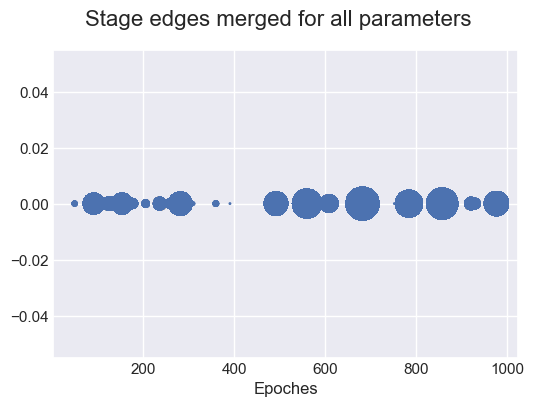

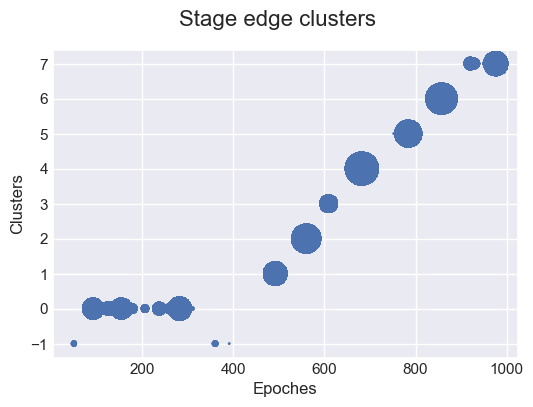

In [88]:
# Clustering parameters k_neighb_max=40, silh_metric_threshold = 0.05

n_stages = 9 # expert choise of result number of stages
df_st_edges_best = df_st_edges_best_dbs

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl= df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]
eps_coef =  df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['Eps_coef'].iloc[0]/100.


st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'dbscan_edges_'+str(n_stages)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = apply_cluster_method(data=df_st_edges_all, cl_method=DBSCAN, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            eps=eps_coef*n_samples, 
                                                            min_samples=int(min_samp_coef*len(st_edges_all)))
edg_labels_all = cluster_method.labels_

# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.2*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
plt.savefig('Stage edges merged.png')

# Plotting clusters    
x = st_edges_all
y = cluster_method.labels_
s = [1.2*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
plt.savefig('Stage edge clusters.png')


In [89]:
# Test

df=df_st_edges_result[df_st_edges_result['N_stages']==9]
df1 = df[(df['Silh']>0.195) & (df['Cen_dist']>21)]
display(df1)
print(df1['Silh'].to_numpy())
silh_max = df['Silh'].max()
display(df[df['Silh']==silh_max])

,N_stages,St_len_min,K_nb_max,N_cl_max,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
355,9,0,45,20,mode,"24,210.13",21.38,0.20,69.91,1.64,"[0, 39, 282, 492, 560, 682, 784, 857, 976, 1046]"


[0.19941028]


,N_stages,St_len_min,K_nb_max,N_cl_max,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
355,9,0,45,20,mode,"24,210.13",21.38,0.20,69.91,1.64,"[0, 39, 282, 492, 560, 682, 784, 857, 976, 1046]"
